In [2]:
import sys
sys.path.append("C:/Users/jnevin/Documents/GitHub/networkdiffusionanalyser")

from netdiffanalyse import IntegrationPipeline
from netdiffanalyse.datahandling.dataintegration import FeatureSetup, MatchClassifier, NetworkIntegrator
from netdiffanalyse.diffusionmodel.diffusionmodel import CustomDiffusionModel, InitialisedDiffusionModel
from netdiffanalyse.analyser.networkanalysis import ResultsAnalyser
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import networkx as nx

test_df = pd.read_csv('dedup_test_df.csv')
test_df.index = test_df.rec_id
test_df = test_df.drop(columns = ['rec_id'])

test_matches = np.load('dedup_test_matches.npy', allow_pickle = True)
test_matches = pd.MultiIndex.from_tuples(test_matches)

test_graph = nx.read_gml('dedup_test_graph.gml')

In [6]:
test_dict = test_df.to_dict()
full_graph_attr = test_graph.copy()

for attribute in test_dict:
    nx.set_node_attributes(full_graph_attr, test_dict[attribute], attribute)

In [7]:
# could be combined into a json config file and pass to integration pipeline
# method that calls all 4 blocks, compares, etc., and then one that wraps and calls on all pairwise comparison
graphs = [full_graph_attr]
test_blocks = {'Block': [['given_name', 'given_name']]}
test_compares = {'Exact':  [['given_name', 'given_name'], ['date_of_birth', 'date_of_birth'],
                          ['suburb', 'suburb'], ['state', 'state']],
                'String': [['surname', 'surname', 'jarowinkler', 0.85], ['address_1', 'address_1', 'levenshtein', 0.85]]}
classifier_name = 'NaiveBayesClassifier'
clustering_alg = 'walktrap_integration'
statuses = ['Susceptible', 'Infected', 'Removed']
compartments = {'NodeStochastic': {'c1': [0.02, 'Infected'], 'c2': [0.01]}}
transition_rules = [["Susceptible", "Infected", "c1"], ["Infected", "Removed", "c2"]]
model_parameters = [['fraction_infected', 0.1]]
simulation_parameters = [4, 300, None, 4]
model_name = 'sir'
training_matches = test_matches

In [8]:
# network integration step
test_feature_setup = FeatureSetup(test_blocks, test_compares, test_df)
test_features = test_feature_setup.calculate_features()

test_classifier = MatchClassifier('NaiveBayesClassifier', test_features, test_matches)
classifier_model = test_classifier.fit_model()
pred_matches = classifier_model.predict(test_features)

test_network_integrator = NetworkIntegrator(test_graph, pred_matches,
                                             'walktrap_integration')
adj_graph = test_network_integrator.integrate_network()

In [10]:
adj_graph

In [11]:
# diffusion model
custom_diffusion_model = CustomDiffusionModel(statuses, compartments,
                                             transition_rules, model_parameters)
initialised_diffusion_model = InitialisedDiffusionModel(adj_graph, custom_diffusion_model)
trends = initialised_diffusion_model.run_diffusion_model(simulation_parameters)

In [12]:
# results analyser setup
results_analyser = ResultsAnalyser(initialised_diffusion_model.model, initialised_diffusion_model.graph,
                                   trends)

In [13]:
results_analyser.get_graph_properties()

{'num_nodes': 646,
 'num_edges': 996,
 'connected': False,
 'degree_cent': {'rec-223-org': 0.024806201550387597,
  'rec-227-org': 0.013953488372093023,
  'rec-344-org': 0.020155038759689922,
  'rec-34-org': 0.03255813953488372,
  'rec-478-org': 0.007751937984496124,
  'rec-452-org': 0.009302325581395349,
  'rec-67-org': 0.027906976744186046,
  'rec-286-org': 0.018604651162790697,
  'rec-335-org': 0.009302325581395349,
  'rec-439-org': 0.0031007751937984496,
  'rec-251-org': 0.009302325581395349,
  'rec-409-org': 0.004651162790697674,
  'rec-70-org': 0.018604651162790697,
  'rec-186-org': 0.010852713178294573,
  'rec-149-org': 0.004651162790697674,
  'rec-364-org': 0.004651162790697674,
  'rec-403-org': 0.013953488372093023,
  'rec-167-org': 0.010852713178294573,
  'rec-262-org': 0.009302325581395349,
  'rec-440-org': 0.0031007751937984496,
  'rec-113-org': 0.006201550387596899,
  'rec-152-org': 0.007751937984496124,
  'rec-99-org': 0.004651162790697674,
  'rec-77-org': 0.00620155038759

In [14]:
results_analyser.get_aggregate_statistics()

{'Susceptible_peak': 0.9009287925696594,
 'Infected_peak': 0.3513931888544891,
 'Removed_peak': 0.6923374613003096,
 'Susceptible_final': 0.20859133126934987,
 'Infected_final': 0.09907120743034056,
 'Removed_final': 0.6923374613003096}

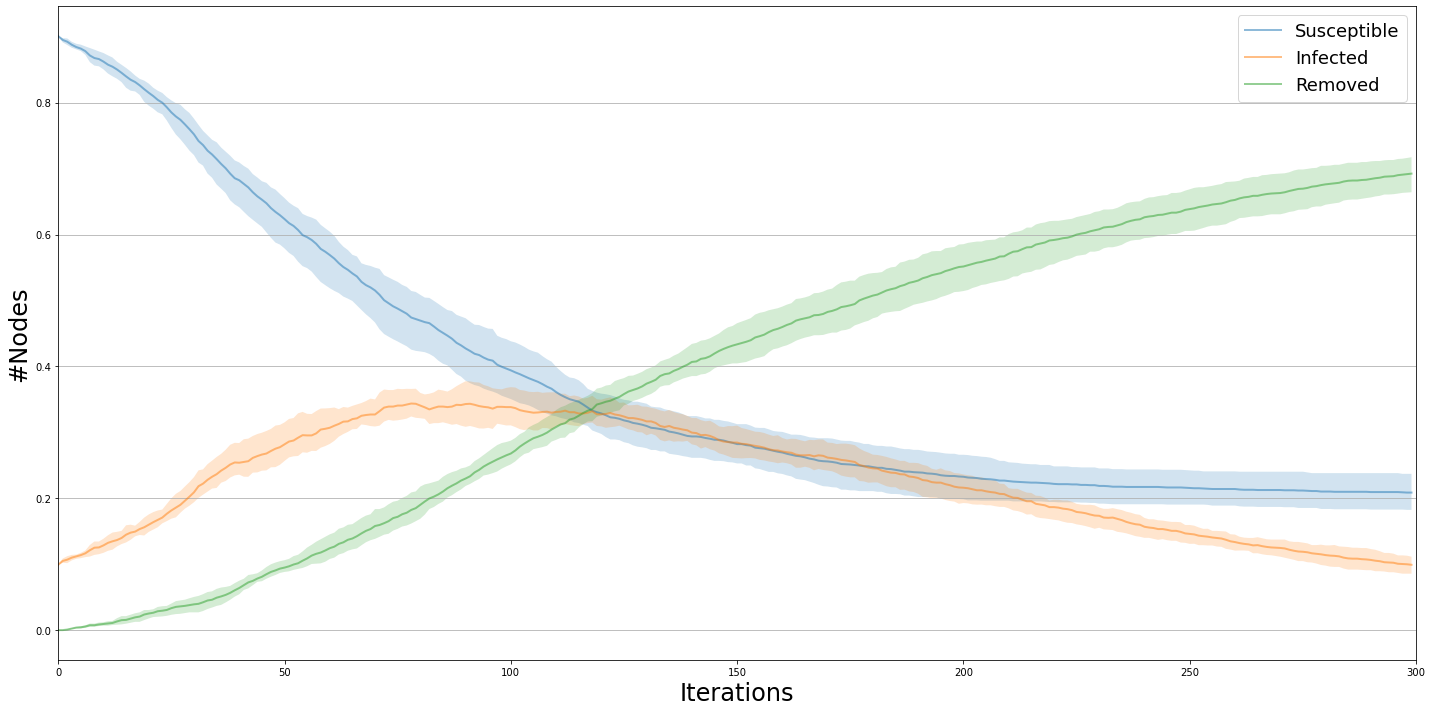

In [15]:
results_analyser.plot_diff_trend()

In [16]:
integration_pipeline = IntegrationPipeline(graphs, test_blocks, test_compares, classifier_name,
                     clustering_alg, statuses, compartments, transition_rules,
                     model_parameters, simulation_parameters, model_name = model_name,
                     training_matches = training_matches)

In [16]:
integration_pipeline.results_analyser.get_graph_properties()

{'num_nodes': 662,
 'num_edges': 996,
 'connected': False,
 'degree_cent': {'rec-223-org': 0.024205748865355523,
  'rec-373-org': 0.0680786686838124,
  'rec-227-org': 0.013615733736762482,
  'rec-294-org': 0.046898638426626324,
  'rec-344-org': 0.019667170953101363,
  'rec-34-org': 0.03177004538577912,
  'rec-478-org': 0.007564296520423601,
  'rec-452-org': 0.009077155824508321,
  'rec-335-org': 0.009077155824508321,
  'rec-439-org': 0.0030257186081694403,
  'rec-409-org': 0.0045385779122541605,
  'rec-145-org': 0.018154311649016642,
  'rec-149-org': 0.0045385779122541605,
  'rec-364-org': 0.0045385779122541605,
  'rec-361-org': 0.028744326777609682,
  'rec-23-org': 0.024205748865355523,
  'rec-403-org': 0.013615733736762482,
  'rec-167-org': 0.01059001512859304,
  'rec-419-org': 0.006051437216338881,
  'rec-262-org': 0.009077155824508321,
  'rec-440-org': 0.0030257186081694403,
  'rec-350-org': 0.012102874432677761,
  'rec-113-org': 0.006051437216338881,
  'rec-152-org': 0.00756429652

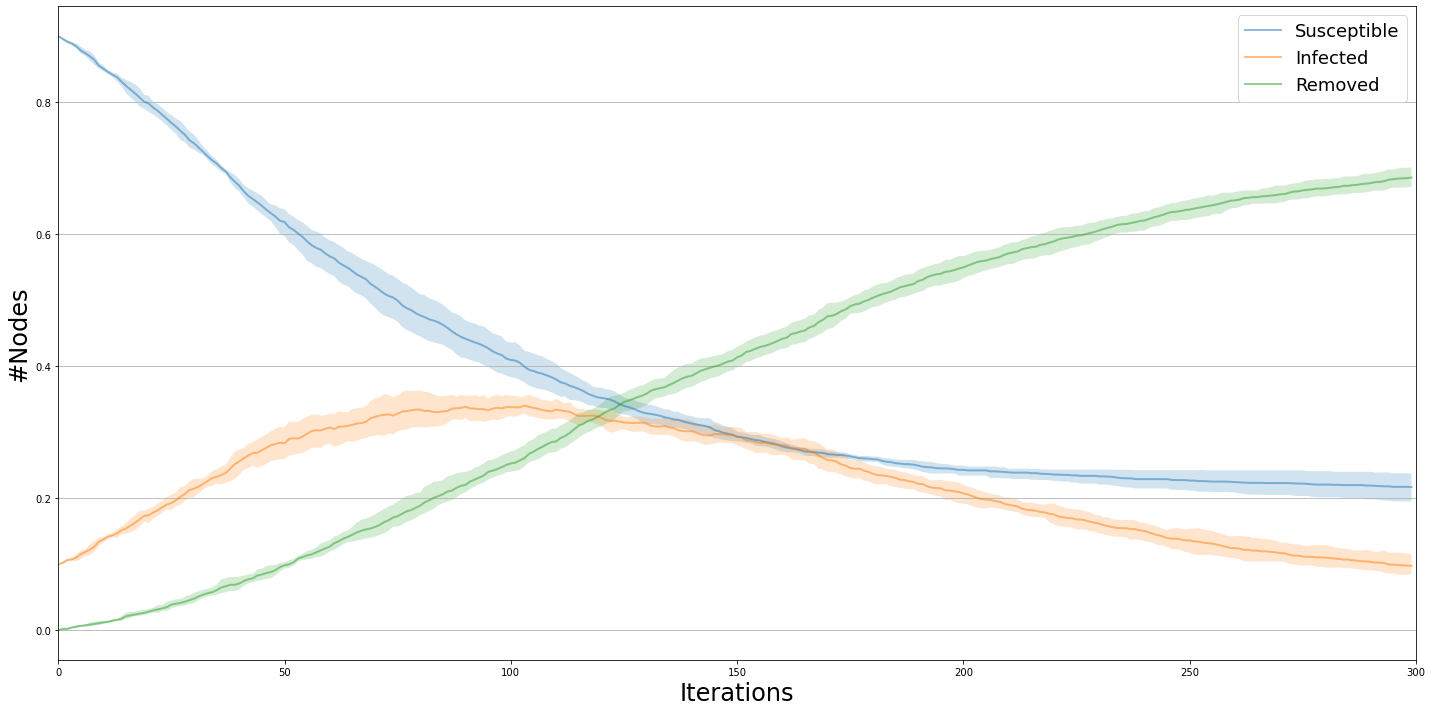

In [17]:
integration_pipeline.results_analyser.plot_diff_trend()

In [18]:
integration_pipeline.results_analyser.get_aggregate_statistics()

{'Susceptible_peak': 0.9003021148036254,
 'Infected_peak': 0.34705438066465255,
 'Removed_peak': 0.6858006042296072,
 'Susceptible_final': 0.21676737160120846,
 'Infected_final': 0.09743202416918428,
 'Removed_final': 0.6858006042296072}

In [ ]:
# integrator checks

In [19]:
len(test_feature_setup.candidate_links) # 2082

2082

In [20]:
test_features.sum(axis=1).value_counts().sort_index(ascending=False) # 142, 145, 30, 9, 376, 1380

6.0     142
5.0     145
4.0      30
3.0       9
2.0     376
1.0    1380
dtype: int64

In [21]:
org_graph = test_network_integrator.graphs
len(org_graph.nodes()) # 922

922

In [22]:
len(adj_graph.nodes()) # 646

646